Iteration 0, Loss: 0.384760
Iteration 200, Loss: 0.119778
Iteration 400, Loss: 0.031467
Iteration 600, Loss: 0.007720
Iteration 800, Loss: 0.002111
Iteration 1000, Loss: 0.000694
Iteration 1200, Loss: 0.000260
Iteration 1400, Loss: 0.000104
Iteration 1600, Loss: 0.000044
Iteration 1800, Loss: 0.000019


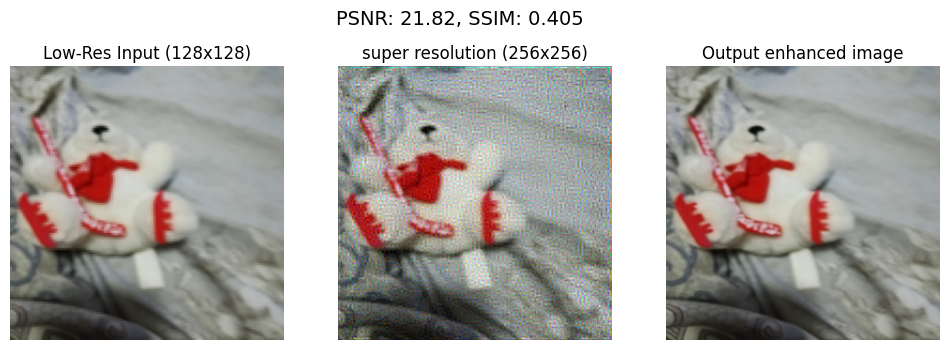

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# -- Load image and generate low-res version --
img_name = "/content/image/205_HUAWEI-P20-LITE_F.jpg"  # Replace with the path to your high-res image
try:
    hr_image = Image.open(img_name).convert('RGB').resize((256, 256)) #increased resolution
except FileNotFoundError:
    print(f"Error: Image file '{img_name}' not found.")
    exit()

lr_image = hr_image.resize((128, 128), Image.BICUBIC)  # 2x downsampling

# Convert to numpy arrays
hr_np = np.array(hr_image).astype(np.float32) / 255.
lr_np = np.array(lr_image).astype(np.float32) / 255.

# Convert to torch tensors
transform = ToTensor()
lr_tensor = transform(lr_image).unsqueeze(0)
hr_tensor = transform(hr_image).unsqueeze(0)

# -- DIP Network Definition --
class DIPNetwork(nn.Module):
    def __init__(self):
        super(DIPNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, 1)
        )

    def forward(self, x):
        return self.net(x)

# -- Setup --
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DIPNetwork().to(device)
input_noise = torch.randn(1, 32, 128, 128, device=device, requires_grad=True) #increased input noise size
optimizer = torch.optim.Adam([input_noise], lr=0.01)
loss_fn = nn.MSELoss()
lr_tensor = lr_tensor.to(device)

# -- Training Loop --
for i in range(2000): #increased iterations
    output = model(input_noise)  # shape: (1, 3, 256, 256)
    downsampled = F.interpolate(output, size=(128, 128), mode='bicubic', align_corners=True)

    loss = loss_fn(downsampled, lr_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.6f}")

# -- Evaluation --
with torch.no_grad():
    sr_image = output.squeeze().cpu().permute(1, 2, 0).clamp(0, 1).numpy()

psnr_score = psnr(hr_np, sr_image)
ssim_score = ssim(hr_np, sr_image, channel_axis=2, data_range=1.0)

# -- Display --
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(lr_np)
plt.title("Low-Res Input (128x128)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sr_image)
plt.title("super resolution (256x256)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hr_np)
plt.title("Output enhanced image")
plt.axis("off")

plt.suptitle(f"PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.3f}", fontsize=14)
plt.show()